# MIMIC EDA

- MIMIC (Medical Information Mart for Intensive Care) is a large, freely-available database comprising deidentified health-related data from patients who were admitted to the critical care units of the Beth Israel Deaconess Medical Center.
- MIMIC-IV contains data from 2008-2019. The data was collected from Metavision bedside monitors.

Main Modules:

- `HOSP` (Hospital): The Hosp module provides all data acquired from the hospital wide electronic health record. Information covered includes patient and admission information, laboratory measurements, microbiology, medication administration, and billed diagnoses.

- `ICU` (Intensive Care Unit) Module: The ICU module contains information collected from the clinical information system used within the ICU. Documented data includes intravenous administrations, ventilator settings, and other charted items.

- `ED` (Emergency Department) Module: The ED module contains data for emergency department patients collected while they are in the ED. Information includes reason for admission, triage assessment, vital signs, and medicine reconciliaton. The subject_id and hadm_id identifiers allow MIMIC-IV-ED to be linked to other MIMIC-IV modules.

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [133]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import openpyxl

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# preprocessing imports
from preprocessing.preprocessor import Preprocessor
from preprocessing.utils import Utils
from config import FILE_PATHS


In [190]:
# Define file paths
file_paths = {
    # ED files
    'edstays': "../ED/edstays.csv",
    'diagnosis': "../ED/diagnosis.csv",
    'triage': "../ED/triage.csv",
    'vitalsigns': '../ED/vitalsign.csv',
    'medrecon': '../ED/medrecon.csv',
    
    # HOSP files
    'admissions': "../HOSP/admissions.csv",
    'transfers': "../HOSP/transfers.csv",
    'patients': "../HOSP/patients.csv",

    # ICU files
    'icu_stays': "../ICU/icustays.csv",
    
    # Data files
    'icd10_codes': "../Data/diagnosis_icd10_codes.csv",
    'icd9_codes': "../Data/diagnosis_icd9_codes.csv"
}

Using the Preprocessor class with configured file paths, we can preprocess all the tables in MIMIC-IV. The preprocessed data is stored in a dictionary, where the keys are the table names and the values are the preprocessed DataFrames.

To note, the main preprocessing steps include:
- Converting datetime columns to datetime objects
- Computing length of stay
- Mapping categorical values to broader categories
- Imputing missing values
- Topic modeling for triage data specifically
- Conversion of dtypes to appropriate types for memory efffiency



In [83]:
# suppress warnings
pd.options.mode.chained_assignment = None

# instantiate the preprocessor class to aid cleaning the data
preprocessor = Preprocessor(file_paths)
# preprocess all the tables in MIMIC-IV
#preprocessed_data = preprocessor.preprocess_all()

# Exploratory Data Analysis (EDA) of the MIMIC-IV dataset 

- Data Distribution and Shape
- Missing Values
- Outliers 
- Correlations
- Feature Engineering

## Hospital (HOSP)Data

- Here we will be using the admissions and transfers tables from the MIMIC-IV dataset.

### Admissions Table

The admissions table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique hadm_id, the admissions table can be considered as a definition table for hadm_id. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.



In [237]:
admissions_df = preprocessor.preprocess_table('admissions')
admissions_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admission_los_hours,is_dead
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-05-06 19:17:00,2180-05-06 23:30:00,0,18.866667,False
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-06-26 15:54:00,2180-06-26 21:31:00,0,24.366667,False
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,White/European Descent,2180-08-05 20:58:00,2180-08-06 01:44:00,0,42.100000,False
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333,False
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,EU OBSERVATION,EMERGENCY ROOM,NaN,NaN,English,SINGLE,White/European Descent,2160-03-03 21:55:00,2160-03-04 06:26:00,0,7.166667,False


In [238]:
admissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            546028 non-null  int64         
 1   hadm_id               546028 non-null  int64         
 2   admittime             546028 non-null  datetime64[ns]
 3   dischtime             546028 non-null  datetime64[ns]
 4   deathtime             11790 non-null   datetime64[ns]
 5   admission_type        546028 non-null  category      
 6   admission_location    546027 non-null  category      
 7   discharge_location    396210 non-null  category      
 8   insurance             536673 non-null  category      
 9   language              545253 non-null  category      
 10  marital_status        532409 non-null  category      
 11  race                  546028 non-null  category      
 12  edregtime             379240 non-null  datetime64[ns]
 13 

### Transfers Table

In [126]:
transfers_df = preprocessor.preprocess_table('transfers')
transfers_df.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,NaN
3,10000032,22841357.0,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,NaN
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12


### Patients Table

In [213]:
patients_df = preprocessor.preprocess_table('patients')
patients_df.head()

Utils.print_info(patients_df)



DataFrame Information for: patients

Shape:
  Rows: 364627, Columns: 7

Column Types:
  int64: 3
  category: 1
  category: 1
  datetime64[ns]: 1
  bool: 1

Missing Values:
  dod: 326326 (89.50%)

Numeric Columns Summary:
         subject_id     anchor_age    anchor_year
count  3.646270e+05  364627.000000  364627.000000
mean   1.501166e+07      48.875097    2150.835404
std    2.885013e+06      20.943316      23.395666
min    1.000003e+07      18.000000    2110.000000
25%    1.251201e+07      29.000000    2131.000000
50%    1.501868e+07      48.000000    2151.000000
75%    1.750900e+07      65.000000    2171.000000
max    1.999999e+07      91.000000    2208.000000

Categorical Columns Summary:
  gender:
    Unique values: 2
    Top 5 values: {'F': 191984, 'M': 172643}
  anchor_year_group:
    Unique values: 5
    Top 5 values: {'2008 - 2010': 101607, '2011 - 2013': 76266, '2014 - 2016': 71640, '2017 - 2019': 65941, '2020 - 2022': 49173}

Sample Data:


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,is_dead
0,10000032,F,52,2180,2014 - 2016,2180-09-09,True
1,10000048,F,23,2126,2008 - 2010,NaT,False
2,10000058,F,33,2168,2020 - 2022,NaT,False
3,10000068,F,19,2160,2008 - 2010,NaT,False
4,10000084,M,72,2160,2017 - 2019,2161-02-13,True


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_90348/4070701591.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patients_df.groupby('anchor_year_group').size().plot.bar()


<Axes: xlabel='anchor_year_group'>

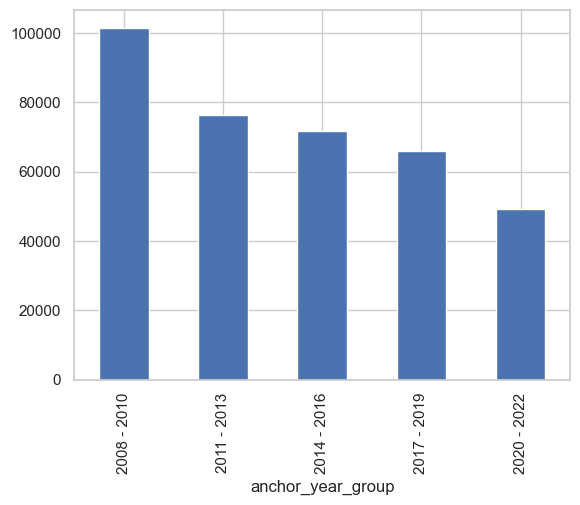

In [128]:
patients_df.groupby('anchor_year_group').size().plot.bar()

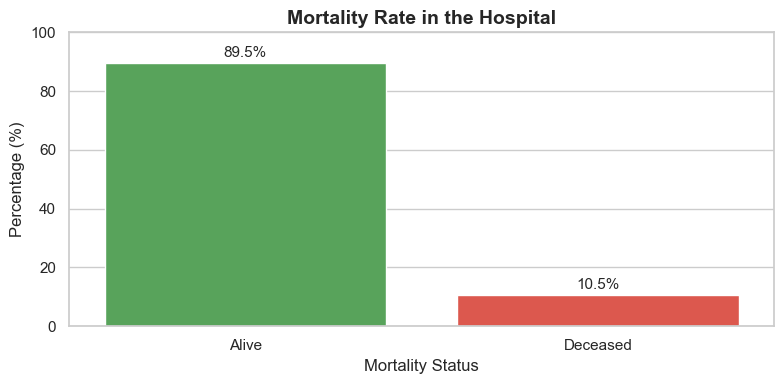

In [121]:
# Visualize mortality rate with enhanced aesthetics using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
colors = ['#4CAF50', '#F44336']  # Green for Alive, Red for Deceased
mortality_counts = patients_df.is_dead.value_counts(normalize=True) * 100
status_labels = {False: 'Alive', True: 'Deceased'}
mortality_df = mortality_counts.rename(index=status_labels).reset_index()
mortality_df.columns = ['Mortality Status', 'Percentage (%)']

ax = sns.barplot(x='Mortality Status', y='Percentage (%)', hue='Mortality Status', data=mortality_df, palette=colors, legend=False)

ax.set_title('Mortality Rate in the Hospital', fontsize=14, weight='bold')
ax.set_ylim(0, 100)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Mortality Status', fontsize=12)

# Add percentage labels above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

### Hospital Diagnosis Table

## Emergency Department (ED) Data

- We will be using the ED Stays, diagnosis, triage, and vital signs t

If a subject does not have an `hadm_id`, it implies the patient visited the Emergency Department but was not subsequently admitted to the hosptial

Specifically:
1. The patient came to the ED for evaluation and treatment
2. After their ED visit, they were discharged directly from the ED rather than being admiteed as an inpatient to the hospital
3. The ED visit did not result in a hospital admission, so no hospital admission ID was generated
4. These patients could represent less severe cases that could be treated and released from the ED without requiring inpatint care
5. The patient may have been sent home, or possibly transfered to another facility, but they did not occupy an inpatient bed at the hospital associated with this ED visit

### ED Stays Table

The edstays table is the primary tracking table for emergency department visits. It provides the time the patient entered the emergency department and the time they left the emergency department.

Table source: Emergency department information system.

Table purpose: Track patient admissions to the emergency department.

Number of rows: 425,087

In [15]:
ed_stays_df = preprocessor.preprocess_table('edstays')
ed_stays_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,ed_los_hours,admitted
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,White/European Descent,AMBULANCE,ADMITTED,4.216667,True
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,White/European Descent,AMBULANCE,ADMITTED,5.616667,True
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,White/European Descent,AMBULANCE,ADMITTED,4.766667,True
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,White/European Descent,AMBULANCE,HOME,13.500000,True
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,White/European Descent,AMBULANCE,ADMITTED,8.100000,True


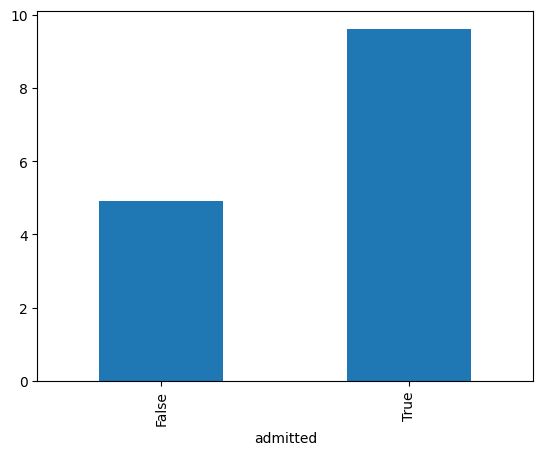

In [16]:
# ed_los_hours vs admitted 

ed_stays_df.groupby("admitted")['ed_los_hours'].mean().plot.bar()
plt.show()

In [17]:
Utils.print_info(ed_stays_df)


DataFrame Information for: edstays

Shape:
  Rows: 425087, Columns: 11

Column Types:
  int64: 2
  float64: 2
  datetime64[ns]: 2
  category: 1
  category: 1
  category: 1
  category: 1
  bool: 1

Missing Values:
  hadm_id: 222071 (52.24%)

Numeric Columns Summary:
         subject_id       hadm_id       stay_id   ed_los_hours
count  4.250870e+05  2.030160e+05  4.250870e+05  425087.000000
mean   1.500871e+07  2.499495e+07  3.499735e+07       7.158327
std    2.878486e+06  2.888745e+06  2.888342e+06       6.628000
min    1.000003e+07  2.000002e+07  3.000001e+07     -22.733333
25%    1.251789e+07  2.248982e+07  3.249799e+07       3.533333
50%    1.501628e+07  2.499935e+07  3.499395e+07       5.466667
75%    1.749900e+07  2.749388e+07  3.750387e+07       8.316667
max    1.999999e+07  2.999981e+07  3.999996e+07     493.069444

Categorical Columns Summary:
  gender:
    Unique values: 2
    Top 5 values: {'F': 229898, 'M': 195189}
  race:
    Unique values: 6
    Top 5 values: {'White/Europ

### Triage Data from ED

The triage table contains information about the patient when they were first triaged in the emergency department. Patients are assessed at triage by a single care provider and asked a series of questions to assess their current health status. Their vital signs are measured and a level of acuity is assigned. Based on the level of acuity, the patient either waits in the waiting room for later attention, or is prioritized for immediate care.

In [81]:
triage_df = preprocessor.preprocess_table('triage')
Utils.print_info(triage_df)

[nltk_data] Downloading package punkt to /Users/julienh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/julienh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 425087, Columns: 12

Column Types:
  float64: 6
  int64: 2
  object: 2
  category: 2

Missing Values:
  temperature: 23415 (5.51%)
  heartrate: 17090 (4.02%)
  resprate: 20353 (4.79%)
  o2sat: 20596 (4.85%)
  sbp: 18291 (4.30%)
  dbp: 19091 (4.49%)
  pain: 12933 (3.04%)
  acuity: 6987 (1.64%)

Numeric Columns Summary:
         subject_id       stay_id    temperature      heartrate       resprate          o2sat            sbp            dbp
count  4.250870e+05  4.250870e+05  401672.000000  407997.000000  404734.000000  404491.000000  406796.000000  405996.000000
mean   1.500871e+07  3.499735e+07      98.015046      85.079891      17.565521      98.471888     135.395352      81.262126
std    2.878486e+06  2.888342e+06       4.008575      18.041690       5.485706      17.040807     240.956408    1057.220031
min    1.000003e+07  3.000001e+07       0.100000       1.000000       0.000000       0.000000       1.000000       0.00000

### Diagnosis Data from ED

The diagnosis table provides billed diagnoses for patients. Diagnoses are determined after discharge from the emergency department.

Table source: Emergency department information system.

Table purpose: Track patient admissions to the emergency department.

Number of rows: 899,050

In [74]:
# get the table and print general information
diagnosis_df = preprocessor.preprocess_table('diagnosis')
Utils.print_info(diagnosis_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 899050, Columns: 8

Column Types:
  int64: 3
  category: 1
  object: 1
  category: 1
  category: 1
  category: 1

Missing Values:
  No missing values

Numeric Columns Summary:
         subject_id       stay_id    icd_version
count  8.990500e+05  8.990500e+05  899050.000000
mean   1.500838e+07  3.500095e+07       9.507241
std    2.879810e+06  2.888942e+06       0.499948
min    1.000003e+07  3.000001e+07       9.000000
25%    1.251347e+07  3.250347e+07       9.000000
50%    1.502022e+07  3.499600e+07      10.000000
75%    1.750406e+07  3.751290e+07      10.000000
max    1.999999e+07  3.999996e+07      10.000000

Categorical Columns Summary:
  icd_code:
    Unique values: 13199
    Top 5 values: {'4019': 26816, 'I10': 21264, 'R079': 13016, '78650': 12398, '25000': 12026}
  icd_title:
    Unique values: 13172
    Top 5 values: {'HYPERTENSION NOS': 26816, 'Essential (primary) hypertension': 21264, 'Chest pain, unspecified': 13016

In [75]:
diagnosis_df.dtypes

subject_id          int64
stay_id             int64
icd_code         category
icd_version         int64
icd_title          object
category_code    category
category         category
subcategory      category
dtype: object

In [76]:
diagnosis_df.sample(10)

,subject_id,stay_id,icd_code,icd_version,icd_title,category_code,category,subcategory
565693,12703255,34841880,R079,10,"Chest pain, unspecified",R07,Symptoms & Abnormal Findings,Symptoms and signs involving the circulatory a...
895918,19924356,35682965,F419,10,"Anxiety disorder, unspecified",F41,Mental & Behavioral,"Neurotic, stress-related and somatoform disorders"
300984,16810289,33927721,30500,9,ALCOHOL ABUSE-UNSPEC,305,Mental & Behavioral,"Neurotic Disorders, Personality Disorders, And..."
343389,17765326,37360060,486,9,"PNEUMONIA,ORGANISM UNSPECIFIED",486,Respiratory System,Pneumonia And Influenza
103756,12361982,30656873,4871,9,FLU W RESP MANIFEST NEC,487,Respiratory System,Pneumonia And Influenza
619073,13897838,31453924,M7989,10,Other specified soft tissue disorders,M79,Musculoskeletal & Connective,Other soft tissue disorders
452200,10208568,30670415,R079,10,"Chest pain, unspecified",R07,Symptoms & Abnormal Findings,Symptoms and signs involving the circulatory a...
42074,10962410,36079211,64893,9,OTH CURR COND-ANTEPARTUM,648,Pregnancy & Childbirth,Complications Mainly Related To Pregnancy
448364,10118356,30497349,F10129,10,"Alcohol abuse with intoxication, unspecified",F10,Mental & Behavioral,Mental and behavioural disorders due to psycho...
125866,12868753,34950435,5589,9,NONINF GASTROENTERIT NEC,558,Digestive System,Noninfective Enteritis And Colitis


In [77]:
diagnosis_df.groupby('icd_version')['category'].value_counts().unstack(fill_value=0)

icd_version,9,10
category,,
Blood & Immune System,4126,4612
Circulatory System,49165,33791
Congenital & Chromosomal,175,119
Digestive System,19122,18755
Ear & Mastoid,0,1412
Endocrine & Metabolic,32815,22513
External Causes,0,27161
Eye & Adnexa,0,2596
Genitourinary System,19732,17632


In [78]:
# save as pickle file
diagnosis_df.to_pickle("../Data/ed_diagnosis_df.pkl")

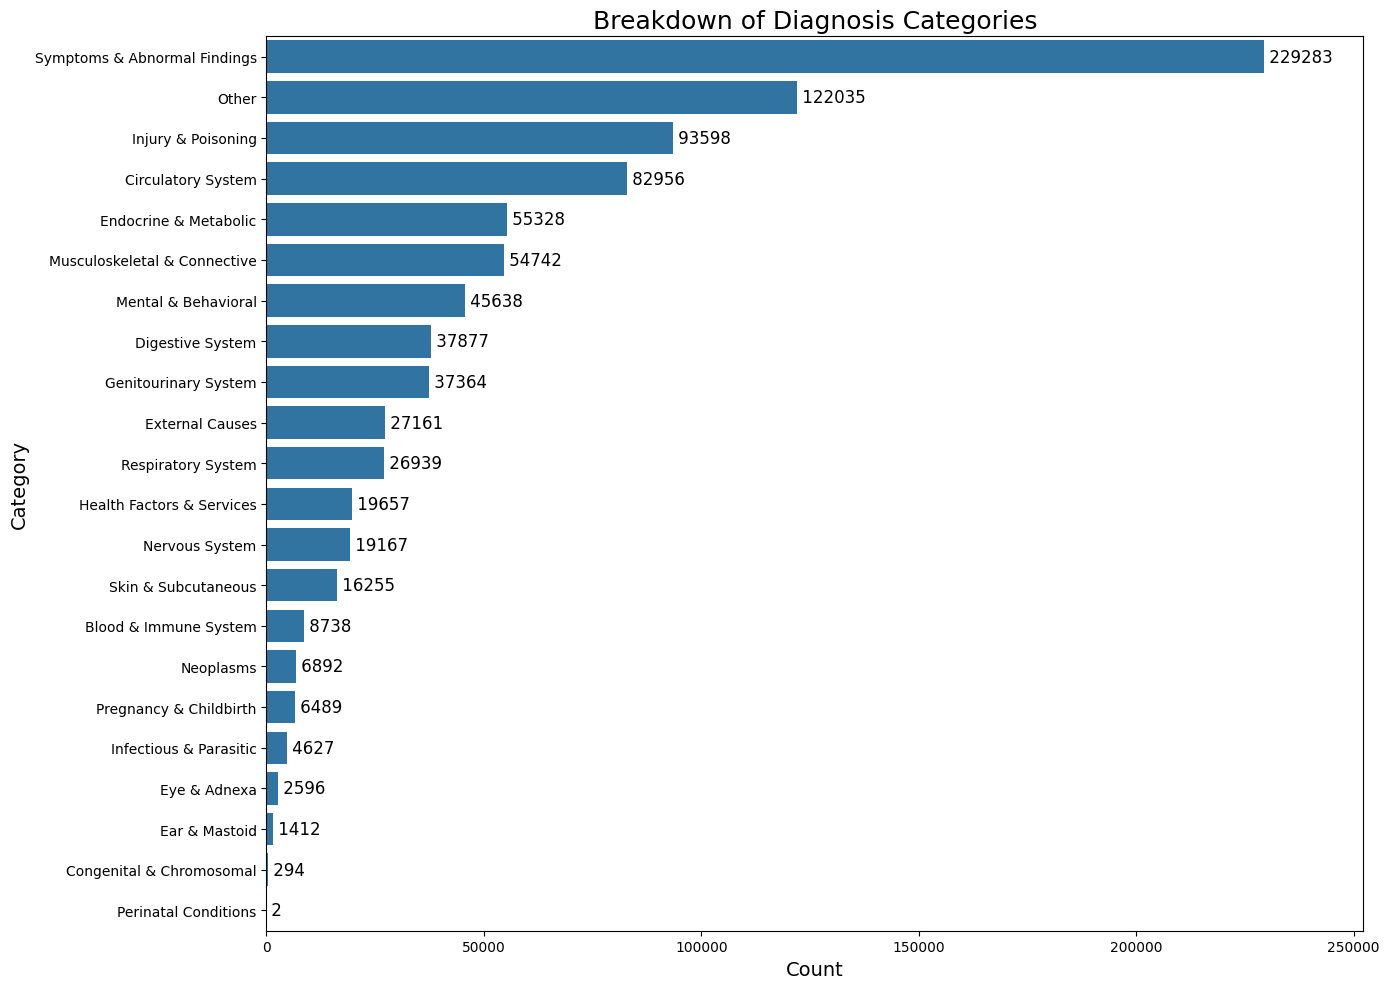

In [79]:
# Improved breakdown of diagnosis category counts with descending order and enhanced visualization
plt.figure(figsize=(14, 10))
category_counts = diagnosis_df['category'].value_counts().sort_values(ascending=False)
sns.barplot(
    x=category_counts.values, 
    y=category_counts.index, 
    orient='h', 
    order=category_counts.index
)
plt.xlim(0, category_counts.max() * 1.1)
plt.title('Breakdown of Diagnosis Categories', fontsize=18)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Add count labels to each bar for better readability
for index, value in enumerate(category_counts.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12)

plt.tight_layout()
plt.show()

### Vital Signs Table

### Final ED Table

In [24]:
# Combining ED tables into a single dataframe

ed_stays_triage_df = ed_stays_df.merge(triage_df, on=['subject_id', 'stay_id'], how='inner')

ed_stays_triage_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,ed_los_hours,...,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,topic,topic_label
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,White/European Descent,AMBULANCE,ADMITTED,4.216667,...,98.4,70.0,16.0,97.0,106.0,63.0,0,3,1,General Pain & Weakness
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,White/European Descent,AMBULANCE,ADMITTED,5.616667,...,98.9,88.0,18.0,97.0,116.0,88.0,10,3,1,General Pain & Weakness
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,White/European Descent,AMBULANCE,ADMITTED,4.766667,...,99.4,105.0,18.0,96.0,106.0,57.0,10,3,5,Limb & Head Pain
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,White/European Descent,AMBULANCE,HOME,13.500000,...,97.8,87.0,14.0,97.0,71.0,43.0,7,2,2,Respiratory & Trauma Symptoms
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,White/European Descent,AMBULANCE,ADMITTED,8.100000,...,98.7,77.0,16.0,98.0,96.0,50.0,13,2,1,General Pain & Weakness


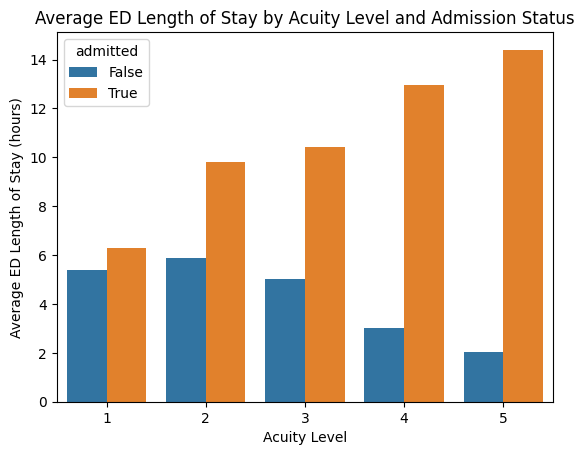

In [23]:
# bar chart of ed_los_hours by acuity level

sns.barplot(data=ed_stays_triage_df, x="acuity", y="ed_los_hours", hue="admitted", errorbar = None)
plt.title("Average ED Length of Stay by Acuity Level and Admission Status")
plt.xlabel("Acuity Level")
plt.ylabel("Average ED Length of Stay (hours)")
plt.show()

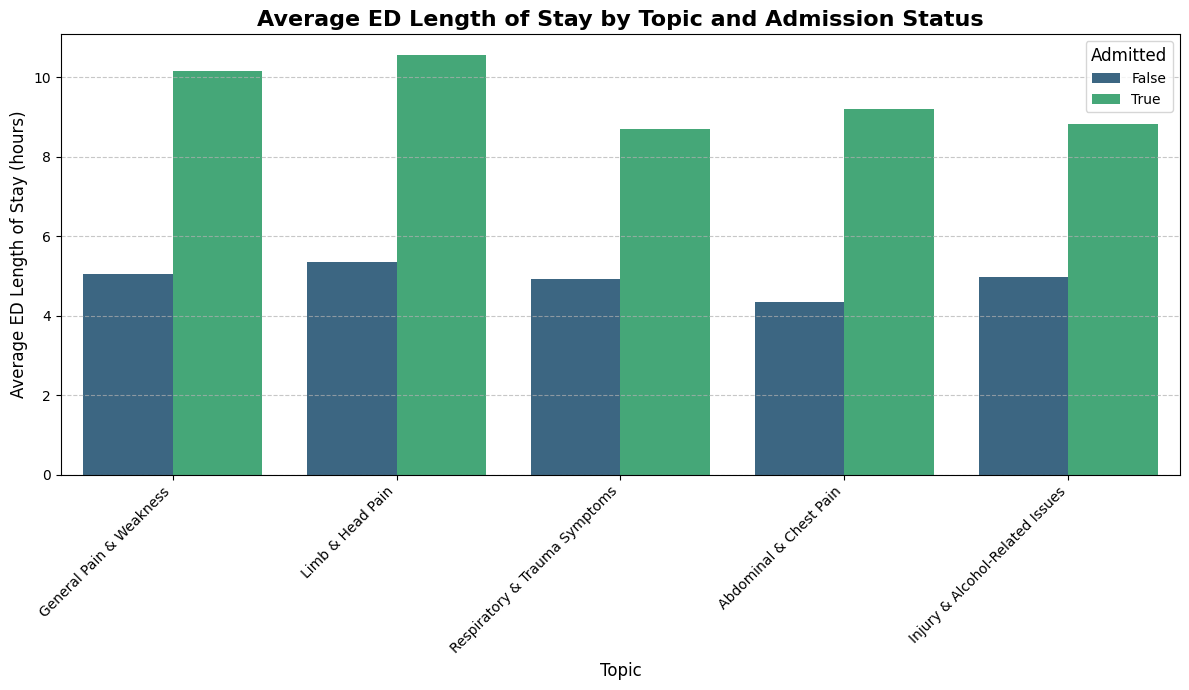

In [34]:
# Set a nice style for the plot

# Create the figure with a larger size and higher DPI for better quality
plt.figure(figsize=(12, 7), dpi=100)

# Create the bar plot with a more appealing color palette
sns.barplot(data=ed_stays_triage_df, x="topic_label", y="ed_los_hours", hue="admitted", 
            errorbar=None, palette="viridis")

# Customize the title and labels
plt.title("Average ED Length of Stay by Topic and Admission Status", fontsize=16, fontweight='bold')
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average ED Length of Stay (hours)", fontsize=12)

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Customize the legend
plt.legend(title="Admitted", title_fontsize='12', fontsize='10')

# Adjust the layout and add a grid for better readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## ICU Data

In [214]:
icu_stays_df = pd.read_csv(file_paths['icu_stays'])

icu_stays_df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113


In [215]:
icu_patients_df = icu_stays_df.merge(patients_df, on='subject_id', how='inner')

In [216]:
Utils.print_info(icu_patients_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 94458, Columns: 14

Column Types:
  int64: 5
  object: 4
  float64: 1
  category: 1
  category: 1
  datetime64[ns]: 1
  bool: 1

Missing Values:
  outtime: 14 (0.01%)
  los: 14 (0.01%)
  dod: 56491 (59.81%)

Numeric Columns Summary:
         subject_id       hadm_id       stay_id           los    anchor_age   anchor_year
count  9.445800e+04  9.445800e+04  9.445800e+04  94444.000000  94458.000000  94458.000000
mean   1.500422e+07  2.498185e+07  3.499832e+07      3.630025     63.039605   2151.567776
std    2.884050e+06  2.884066e+06  2.886407e+06      5.402473     16.716605     23.541546
min    1.000003e+07  2.000009e+07  3.000015e+07      0.001250     18.000000   2110.000000
25%    1.251463e+07  2.248212e+07  3.250678e+07      1.096212     53.000000   2132.000000
50%    1.500554e+07  2.498248e+07  3.499944e+07      1.965648     65.000000   2151.000000
75%    1.751758e+07  2.746506e+07  3.749099e+07      3.862575     76.000000

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,gender,anchor_age,anchor_year,anchor_year_group,dod,is_dead
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,F,52,2180,2014 - 2016,2180-09-09,True
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,F,86,2150,2008 - 2010,2152-01-30,True
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,F,73,2186,2008 - 2010,2193-08-26,True
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,F,55,2157,2011 - 2013,NaT,False
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,F,55,2157,2011 - 2013,NaT,False


In [217]:
# convert los to los_hours
icu_patients_df['los_hours'] = icu_patients_df['los'].apply(lambda x: x * 24)

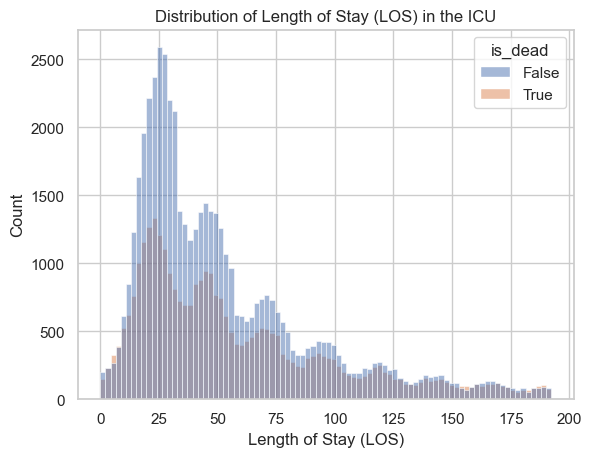

In [220]:
# Remove outliers
Q1 = icu_patients_df['los_hours'].quantile(0.25)
Q3 = icu_patients_df['los_hours'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = icu_patients_df[(icu_patients_df['los_hours'] >= lower_bound) & (icu_patients_df['los_hours'] <= upper_bound)]

# Visualize the distribution of normalized los
sns.histplot(data=filtered_df, x='los_hours', hue = 'is_dead')
plt.title('Distribution of Length of Stay (LOS) in the ICU')
plt.xlabel('Length of Stay (LOS)')
plt.ylabel('Count')
plt.show()

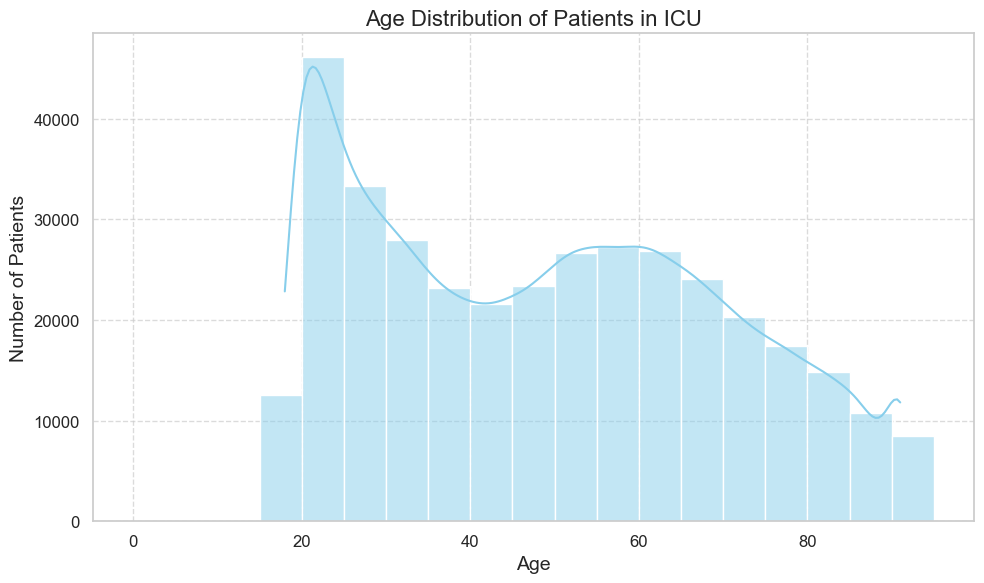

In [227]:
# Visualize age distribution of patients in ICU with enhanced aesthetics
plt.figure(figsize=(10, 6))
sns.histplot(data=patients_df, x='anchor_age', bins=np.arange(0, 100, 5), kde=True, color='skyblue')
plt.title('Age Distribution of Patients in ICU', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

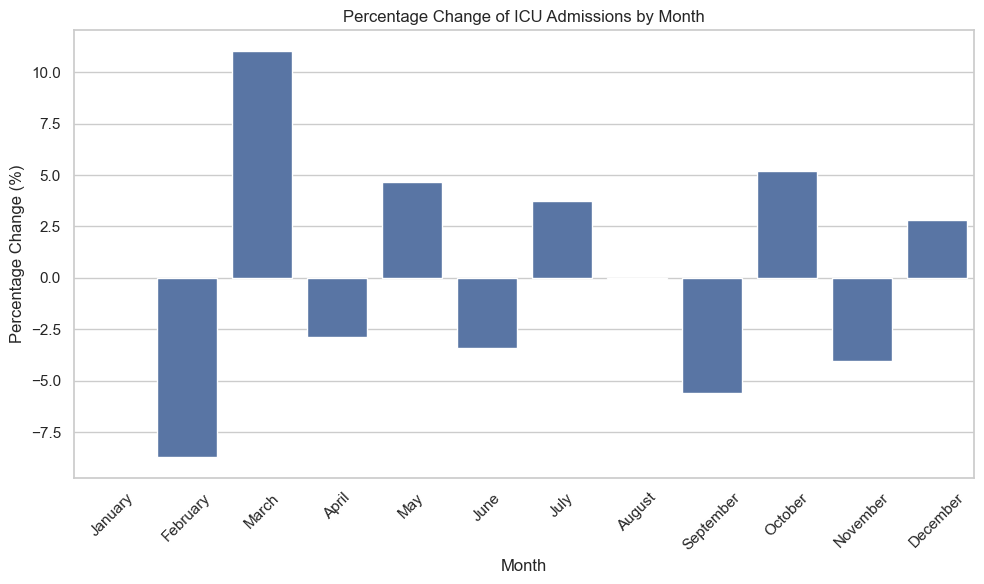

In [235]:
# Monthly analysis with percentage change

# Ensure 'intime' is datetime
filtered_df['intime'] = pd.to_datetime(filtered_df['intime'])

# Extract month from 'intime'
filtered_df['month'] = filtered_df['intime'].dt.month

# Map month numbers to month names
import calendar
filtered_df['month_name'] = filtered_df['month'].apply(lambda x: calendar.month_name[x])

# Count ICU admissions per month
month_order = list(range(1, 13))
month_counts = filtered_df['month'].value_counts().reindex(month_order)

# Calculate percentage change by month
month_pct_change = month_counts.pct_change() * 100

# Plot Percentage Change in ICU admissions by month
plt.figure(figsize=(10, 6))
sns.barplot(x=[calendar.month_name[m] for m in month_order], y=month_pct_change.values, legend=False)
plt.title('Percentage Change of ICU Admissions by Month')
plt.xlabel('Month')
plt.ylabel('Percentage Change (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Merging Tables

In [239]:
def create_final_table(patients_df, edstays_df, diagnosis_df, nonfatal_level2_map_df):
    # Merge patients and edstays data
    merged_df = pd.merge(patients_df, edstays_df, on='subject_id', how='inner')

    # Group diagnosis data by stay_id
    diagnosis_grouped_df = diagnosis_df.groupby('stay_id').agg(list).reset_index()

    # Merge with the grouped diagnosis data
    merged_df = pd.merge(merged_df, diagnosis_grouped_df, on='stay_id', how='inner')

    # Categorize age
    merged_df['age_category'] = merged_df['anchor_age'].apply(Utils.categorize_age)

    # Extract primary ICD codes
    merged_df['primary_ICD'] = merged_df['icd_code'].apply(Utils.get_first_element)
    merged_df['primary_ICD_version'] = merged_df['icd_version'].apply(Utils.get_first_element)
    merged_df['primary_ICD_title'] = merged_df['icd_title'].apply(Utils.get_first_element)

    # Extract ICD ranges
    icd9_ranges = Utils.extract_icd_ranges(nonfatal_level2_map_df, "Cause Name", "ICD9", "ICD9 Used in Hospital/Claims Analyses")
    icd10_ranges = Utils.extract_icd_ranges(nonfatal_level2_map_df, "Cause Name", "ICD10", "ICD10 Used in Hospital/Claims Analyses")

    # Map ICD codes to disease categories
    merged_df["map_disease_category"] = merged_df.apply(Utils.code_map_from_icd_list, axis=1, args=(icd9_ranges, icd10_ranges))

    # Filter out unknown disease categories
    merged_df = merged_df[merged_df["map_disease_category"] != "Unknown"]
    merged_df["case"] = 1

    # Group by relevant columns and aggregate
    group_list = ["gender_x", 'age_category', "map_disease_category", "anchor_year_group"]
    aggregated_merge_df = merged_df.groupby(group_list).agg({'case': 'sum'}).reset_index()

    return aggregated_merge_df


In [240]:
# Example usage
patients_df = pd.read_csv(file_paths['patients'])
edstays_df = pd.read_csv(file_paths['edstays'])
diagnosis_df = pd.read_csv(file_paths['diagnosis'])
nonfatal_level2_map_df = pd.read_excel("../dataset/IHME_GBD_2021_NONFATAL_CAUSE_ICD_CODE_MAP_Y2024M05D16.XLSX", header=1)

final_table = create_final_table(patients_df, edstays_df, diagnosis_df, nonfatal_level2_map_df)
final_table.head()

,gender_x,age_category,map_disease_category,anchor_year_group,case
0,F,15-49 years,Cardiovascular diseases,2008 - 2010,2059
1,F,15-49 years,Cardiovascular diseases,2011 - 2013,1336
2,F,15-49 years,Cardiovascular diseases,2014 - 2016,1665
3,F,15-49 years,Cardiovascular diseases,2017 - 2019,1601
4,F,15-49 years,Chronic respiratory diseases,2008 - 2010,2582


In [241]:
# save as a pickle file
final_table.to_pickle("../Data/disease_incidence_final_table.pkl")

In [242]:
for col in final_table.columns:
    # print unique values for each categorical column
    print(f"{col}: {final_table[col].nunique()}")


gender_x: 2
age_category: 3
map_disease_category: 23
anchor_year_group: 4
case: 387


In [243]:
Utils.print_info(final_table)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 522, Columns: 5

Column Types:
  object: 4
  int64: 1

Missing Values:
  No missing values

Numeric Columns Summary:
              case
count   522.000000
mean    761.254789
std     907.484891
min       1.000000
25%      61.250000
50%     414.500000
75%    1178.750000
max    6307.000000

Categorical Columns Summary:
  gender_x:
    Unique values: 2
    Top 5 values: {'F': 263, 'M': 259}
  age_category:
    Unique values: 3
    Top 5 values: {'15-49 years': 177, '50-69 years': 176, '70+ years': 169}
  map_disease_category:
    Unique values: 23
    Top 5 values: {'Cardiovascular diseases': 24, 'Chronic respiratory diseases': 24, 'Transport injuries': 24, 'Substance use disorders': 24, 'Skin and subcutaneous diseases': 24}
  anchor_year_group:
    Unique values: 4
    Top 5 values: {'2011 - 2013': 131, '2014 - 2016': 131, '2017 - 2019': 131, '2008 - 2010': 129}

Sample Data:


,gender_x,age_category,map_disease_category,anchor_year_group,case
0,F,15-49 years,Cardiovascular diseases,2008 - 2010,2059
1,F,15-49 years,Cardiovascular diseases,2011 - 2013,1336
2,F,15-49 years,Cardiovascular diseases,2014 - 2016,1665
3,F,15-49 years,Cardiovascular diseases,2017 - 2019,1601
4,F,15-49 years,Chronic respiratory diseases,2008 - 2010,2582


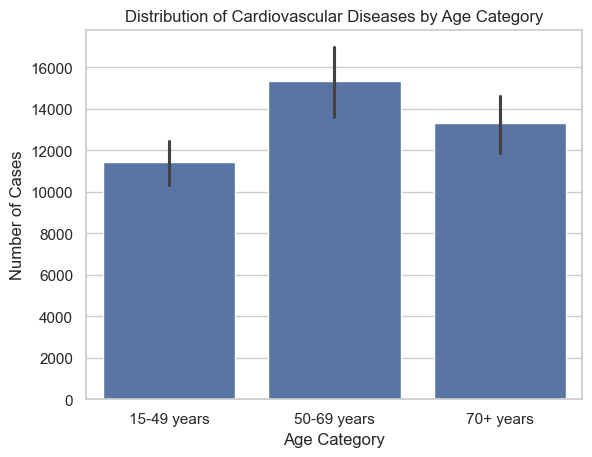

In [188]:
# isolate by map_disease_category equals Cardiovascular diseases and visualize that
cardiovascular_df = final_table[final_table["map_disease_category"] == "Cardiovascular diseases"]
sns.barplot(data=cardiovascular_df, x="age_category", y="case", estimator=sum)
plt.title("Distribution of Cardiovascular Diseases by Age Category")
plt.xlabel("Age Category")
plt.ylabel("Number of Cases")
plt.show()

# Conclusions

In [15]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = ['ed_los_hours', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity']
categorical_features = ['gender', 'race_x', 'arrival_transport', 'disposition', 'admission_type', 'admission_location', 
                        'insurance', 'language', 'marital_status', 'category_code', 'category', 'topic']

# Create preprocessing steps for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit the preprocessor on the training data and transform both training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert to dense arrays if needed (e.g., for certain models)
X_train_preprocessed = X_train_preprocessed.toarray()
X_test_preprocessed = X_test_preprocessed.toarray()

print("Preprocessed training data shape:", X_train_preprocessed.shape)
print("Preprocessed test data shape:", X_test_preprocessed.shape)



Preprocessed training data shape: (1175972, 1209)
Preprocessed test data shape: (293993, 1209)


In [16]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train_preprocessed, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_preprocessed)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = rf_classifier.feature_importances_
feature_names = (numeric_features + 
                 preprocessor.named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names(categorical_features).tolist())

# Sort features by importance
sorted_idx = feature_importance.argsort()
top_10_idx = sorted_idx[-10:]

print("\nTop 10 Most Important Features:")
for idx in top_10_idx[::-1]:
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")


Random Forest Classifier Accuracy: 0.9735

Classification Report:
              precision    recall  f1-score   support

       False       0.97      1.00      0.99    286189
        True       0.00      0.00      0.00      7804

    accuracy                           0.97    293993
   macro avg       0.49      0.50      0.49    293993
weighted avg       0.95      0.97      0.96    293993



/Users/julienh/Desktop/MADS/Milestone1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julienh/Desktop/MADS/Milestone1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julienh/Desktop/MADS/Milestone1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

: 